In [3]:
import pandas as pd
import numpy as np
import tabulate as tb
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

/Users/ninaginny/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# DATASET

In [4]:
data = pd.read_csv('Dataset for linear regression.csv')
data.pop("Unnamed: 0")
data

#Remove Xmas dates
data = data[data['Xmas'] != 1.0]

#n=3305
data = data[data['DSN'] >= 0]


# Convert the 'Winter' column to string type
data['Winter'] = data['Winter'].astype(str)

# Extract the first year from the string and convert it to integer
data['Winter'] = data['Winter'].str.split('/').str[0].astype(int)

# Check the updated 'Winter' column
print(data['Winter'].head())


data['f_c'] = np.where(data['start_year'] < 2007, '0', '1')


# Add the squared term for DSN
data['DSN_sq'] = data['DSN']**2

1    1990
2    1990
3    1990
4    1990
5    1990
Name: Winter, dtype: int64


In [5]:
data.columns

Index(['demand_date', 'peak_demand', 'TO', 'TE', 'Winter', 'start_year',
       'Nov_date', 'DSN', 'DOW', 'DOW2', 'Xmas', 'Winter1', 'Winter2',
       'Winter3', 'Winter4', 'Winter5', 'Winter6', 'Winter7', 'Winter8',
       'Winter9', 'Winter10', 'Winter11', 'Winter12', 'Winter13', 'Winter14',
       'Winter15', 'Winter16', 'Winter17', 'Winter18', 'Winter19', 'Winter20',
       'Winter21', 'Winter22', 'Winter23', 'Winter24', 'Winter25', 'Winter26',
       'TEW1', 'TEW2', 'TEW3', 'TEW4', 'TEW5', 'TEW6', 'TEW7', 'TEW8', 'TEW9',
       'TEW10', 'TEW11', 'TEW12', 'TEW13', 'TEW14', 'TEW15', 'TEW16', 'TEW17',
       'TEW18', 'TEW19', 'TEW20', 'TEW21', 'TEW22', 'TEW23', 'TEW24', 'TEW25',
       'TEW26', 'f_c', 'DSN_sq'],
      dtype='object')

In [6]:
summary_wind = pd.read_csv("readings_at_6pm.csv")

summary_wind['time'] = pd.to_datetime(summary_wind['time'])

summary_wind['date'] = summary_wind['time'].dt.date
summary_wind.drop(columns=['time'], inplace=True)

summary_wind['date'] = pd.to_datetime(summary_wind['date'])


data['demand_date'] = pd.to_datetime(data['demand_date'])

In [7]:
merged_data = pd.merge(data, summary_wind, how='left', left_on='demand_date', right_on='date')

# Drop the extra datetime column (if it was added)
merged_data.drop(columns=['date','Unnamed: 0'], inplace=True, errors='ignore')

merged_data

,demand_date,peak_demand,TO,TE,Winter,start_year,Nov_date,DSN,DOW,DOW2,...,TEW25,TEW26,f_c,DSN_sq,temp_GB,pop_temp (UK),offshore (current),offshore (current + future),onshore (current),onshore (current + future)
0,1991-01-02,46861.0,6.624140,7.328970,1990,1990,1990-11-01,62,Wednesday,4,...,0.0,0.000000,0,3844,6.505318,6.870179,0.964382,0.973978,0.808802,0.809469
1,1991-01-03,48295.5,5.403947,6.366459,1990,1990,1990-11-01,63,Thursday,5,...,0.0,0.000000,0,3969,4.380913,4.629734,0.926980,0.944425,0.666188,0.667638
2,1991-01-04,47227.0,3.424677,4.895568,1990,1990,1990-11-01,64,Friday,6,...,0.0,0.000000,0,4096,4.080848,3.845943,0.953200,0.964664,0.837248,0.839300
3,1991-01-05,42109.0,4.940087,4.917828,1990,1990,1990-11-01,65,Saturday,7,...,0.0,0.000000,0,4225,4.714163,4.693791,0.804935,0.880028,0.813140,0.810174
4,1991-01-06,39458.5,4.187367,4.552597,1990,1990,1990-11-01,66,Sunday,1,...,0.0,0.000000,0,4356,3.592860,3.540339,0.864293,0.891150,0.533717,0.538483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3196,2015-12-13,45497.5,5.388930,6.643740,2015,2015,2015-11-01,42,Sunday,1,...,0.0,6.643740,1,1764,6.175923,6.352180,0.250841,0.267454,0.098855,0.098320
3197,2015-12-14,48426.5,6.964914,6.804327,2015,2015,2015-11-01,43,Monday,2,...,0.0,6.804327,1,1849,7.473052,7.554696,0.280516,0.200488,0.152439,0.152522
3198,2015-12-15,48018.0,9.513962,8.159145,2015,2015,2015-11-01,44,Tuesday,3,...,0.0,8.159145,1,1936,10.215379,10.449899,0.858350,0.891299,0.500198,0.500152
3199,2015-12-16,47622.0,11.423531,9.791338,2015,2015,2015-11-01,45,Wednesday,4,...,0.0,9.791338,1,2025,12.111213,12.423343,0.816072,0.845028,0.318863,0.319897


In [8]:
merged_data['DOW2'] = pd.Categorical(merged_data['DOW2'])

merged_data['DOW2'] = merged_data['DOW2'].cat.reorder_categories([7] + list(merged_data['DOW2'].cat.categories.difference([7])))


In [9]:
merged_data['DOW2']

0       4
1       5
2       6
3       7
4       1
       ..
3196    1
3197    2
3198    3
3199    4
3200    5
Name: DOW2, Length: 3201, dtype: category
Categories (7, int64): [7, 1, 2, 3, 4, 5, 6]

In [10]:
dow2_column = merged_data['DOW2']

# One-hot encode 'DOW2' column
data_encoded = pd.get_dummies(merged_data, columns=['DOW2'], prefix=['DOW2'])

# Concatenate the original 'DOW2' column with the one-hot encoded columns
merged_data = pd.concat([dow2_column, data_encoded], axis=1)

merged_data

,DOW2,demand_date,peak_demand,TO,TE,Winter,start_year,Nov_date,DSN,DOW,...,offshore (current + future),onshore (current),onshore (current + future),DOW2_7,DOW2_1,DOW2_2,DOW2_3,DOW2_4,DOW2_5,DOW2_6
0,4,1991-01-02,46861.0,6.624140,7.328970,1990,1990,1990-11-01,62,Wednesday,...,0.973978,0.808802,0.809469,0,0,0,0,1,0,0
1,5,1991-01-03,48295.5,5.403947,6.366459,1990,1990,1990-11-01,63,Thursday,...,0.944425,0.666188,0.667638,0,0,0,0,0,1,0
2,6,1991-01-04,47227.0,3.424677,4.895568,1990,1990,1990-11-01,64,Friday,...,0.964664,0.837248,0.839300,0,0,0,0,0,0,1
3,7,1991-01-05,42109.0,4.940087,4.917828,1990,1990,1990-11-01,65,Saturday,...,0.880028,0.813140,0.810174,1,0,0,0,0,0,0
4,1,1991-01-06,39458.5,4.187367,4.552597,1990,1990,1990-11-01,66,Sunday,...,0.891150,0.533717,0.538483,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3196,1,2015-12-13,45497.5,5.388930,6.643740,2015,2015,2015-11-01,42,Sunday,...,0.267454,0.098855,0.098320,0,1,0,0,0,0,0
3197,2,2015-12-14,48426.5,6.964914,6.804327,2015,2015,2015-11-01,43,Monday,...,0.200488,0.152439,0.152522,0,0,1,0,0,0,0
3198,3,2015-12-15,48018.0,9.513962,8.159145,2015,2015,2015-11-01,44,Tuesday,...,0.891299,0.500198,0.500152,0,0,0,1,0,0,0
3199,4,2015-12-16,47622.0,11.423531,9.791338,2015,2015,2015-11-01,45,Wednesday,...,0.845028,0.318863,0.319897,0,0,0,0,1,0,0


In [11]:
merged_data

,DOW2,demand_date,peak_demand,TO,TE,Winter,start_year,Nov_date,DSN,DOW,...,offshore (current + future),onshore (current),onshore (current + future),DOW2_7,DOW2_1,DOW2_2,DOW2_3,DOW2_4,DOW2_5,DOW2_6
0,4,1991-01-02,46861.0,6.624140,7.328970,1990,1990,1990-11-01,62,Wednesday,...,0.973978,0.808802,0.809469,0,0,0,0,1,0,0
1,5,1991-01-03,48295.5,5.403947,6.366459,1990,1990,1990-11-01,63,Thursday,...,0.944425,0.666188,0.667638,0,0,0,0,0,1,0
2,6,1991-01-04,47227.0,3.424677,4.895568,1990,1990,1990-11-01,64,Friday,...,0.964664,0.837248,0.839300,0,0,0,0,0,0,1
3,7,1991-01-05,42109.0,4.940087,4.917828,1990,1990,1990-11-01,65,Saturday,...,0.880028,0.813140,0.810174,1,0,0,0,0,0,0
4,1,1991-01-06,39458.5,4.187367,4.552597,1990,1990,1990-11-01,66,Sunday,...,0.891150,0.533717,0.538483,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3196,1,2015-12-13,45497.5,5.388930,6.643740,2015,2015,2015-11-01,42,Sunday,...,0.267454,0.098855,0.098320,0,1,0,0,0,0,0
3197,2,2015-12-14,48426.5,6.964914,6.804327,2015,2015,2015-11-01,43,Monday,...,0.200488,0.152439,0.152522,0,0,1,0,0,0,0
3198,3,2015-12-15,48018.0,9.513962,8.159145,2015,2015,2015-11-01,44,Tuesday,...,0.891299,0.500198,0.500152,0,0,0,1,0,0,0
3199,4,2015-12-16,47622.0,11.423531,9.791338,2015,2015,2015-11-01,45,Wednesday,...,0.845028,0.318863,0.319897,0,0,0,0,1,0,0


In [12]:
merged_data.columns

Index(['DOW2', 'demand_date', 'peak_demand', 'TO', 'TE', 'Winter',
       'start_year', 'Nov_date', 'DSN', 'DOW', 'Xmas', 'Winter1', 'Winter2',
       'Winter3', 'Winter4', 'Winter5', 'Winter6', 'Winter7', 'Winter8',
       'Winter9', 'Winter10', 'Winter11', 'Winter12', 'Winter13', 'Winter14',
       'Winter15', 'Winter16', 'Winter17', 'Winter18', 'Winter19', 'Winter20',
       'Winter21', 'Winter22', 'Winter23', 'Winter24', 'Winter25', 'Winter26',
       'TEW1', 'TEW2', 'TEW3', 'TEW4', 'TEW5', 'TEW6', 'TEW7', 'TEW8', 'TEW9',
       'TEW10', 'TEW11', 'TEW12', 'TEW13', 'TEW14', 'TEW15', 'TEW16', 'TEW17',
       'TEW18', 'TEW19', 'TEW20', 'TEW21', 'TEW22', 'TEW23', 'TEW24', 'TEW25',
       'TEW26', 'f_c', 'DSN_sq', 'temp_GB', 'pop_temp (UK)',
       'offshore (current)', 'offshore (current + future)',
       'onshore (current)', 'onshore (current + future)', 'DOW2_7', 'DOW2_1',
       'DOW2_2', 'DOW2_3', 'DOW2_4', 'DOW2_5', 'DOW2_6'],
      dtype='object')

# GAM TRAINING

In [13]:
import numpy as np
import pandas as pd
from pygam import LinearGAM, s, f


gam_data = {
    'DOW2_1': merged_data['DOW2_1'],
    'DOW2_2': merged_data['DOW2_2'],
    'DOW2_3': merged_data['DOW2_3'],
    'DOW2_4': merged_data['DOW2_4'],
    'DOW2_5': merged_data['DOW2_5'],
    'DOW2_6': merged_data['DOW2_6'],
    'DOW2_7': merged_data['DOW2_7'],
    'f_c': merged_data['f_c'],
    'Winter1': merged_data['Winter1'],
    'Winter2': merged_data['Winter2'],
    'Winter3': merged_data['Winter3'],
    'Winter4': merged_data['Winter4'],
    'Winter5': merged_data['Winter5'],
    'Winter6': merged_data['Winter6'],
    'Winter7': merged_data['Winter7'],
    'Winter8': merged_data['Winter8'],
    'Winter9': merged_data['Winter9'],
    'Winter10': merged_data['Winter10'],
    'Winter11': merged_data['Winter11'],
    'Winter12': merged_data['Winter12'],
    'Winter13': merged_data['Winter13'],
    'Winter14': merged_data['Winter14'],
    'Winter15': merged_data['Winter15'],
    'Winter16': merged_data['Winter16'],
    'Winter17': merged_data['Winter17'],
    'Winter18': merged_data['Winter18'],
    'Winter19': merged_data['Winter19'],
    'Winter20': merged_data['Winter20'],
    'Winter21': merged_data['Winter21'],
    'Winter22': merged_data['Winter22'],
    'Winter23': merged_data['Winter23'],
    'Winter24': merged_data['Winter24'],
    'Winter25': merged_data['Winter25'],
    'Winter26': merged_data['Winter26'],
    'DSN': merged_data['DSN'],
    'TEW1': merged_data['TEW1'],
    'TEW2': merged_data['TEW2'],
    'TEW3': merged_data['TEW3'],
    'TEW4': merged_data['TEW4'],
    'TEW5': merged_data['TEW5'],
    'TEW6': merged_data['TEW6'],
    'TEW7': merged_data['TEW7'],
    'TEW8': merged_data['TEW8'],
    'TEW9': merged_data['TEW9'],
    'TEW10': merged_data['TEW10'],
    'TEW11': merged_data['TEW11'],
    'TEW12': merged_data['TEW12'],
    'TEW13': merged_data['TEW13'],
    'TEW14': merged_data['TEW14'],
    'TEW15': merged_data['TEW15'],
    'TEW16': merged_data['TEW16'],
    'TEW17': merged_data['TEW17'],
    'TEW18': merged_data['TEW18'],
    'TEW19': merged_data['TEW19'],
    'TEW20': merged_data['TEW20'],
    'TEW21': merged_data['TEW21'],
    'TEW22': merged_data['TEW22'],
    'TEW23': merged_data['TEW23'],
    'TEW24': merged_data['TEW24'],
    'TEW25': merged_data['TEW25'],
    'TEW26': merged_data['TEW26'],
    'peak_demand': merged_data['peak_demand']
}
df = pd.DataFrame(gam_data)

# Define terms for the GAM
terms = f(0)
for i in range(2, 36):  # Normal terms 
    terms += f(i)

for i in range(37, 61):  # TE and DSN Smooth terms
    terms += s(i)

# Fit the GAM model
gam = LinearGAM(terms=terms).fit(df.iloc[:, :-1], df.iloc[:, -1])

# Summary of the model
print(gam.summary())

# Predictions
predictions = gam.predict(df.iloc[:, :-1])



LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    392.7902
Link Function:                     IdentityLink Log Likelihood:                                -45855.8801
Number of Samples:                         3201 AIC:                                            92499.3406
                                                AICc:                                           92610.1409
                                                GCV:                                           849677.8072
                                                Scale:                                         664338.2009
                                                Pseudo R-Squared:                                   0.9739
Feature Function                  Lam

/var/folders/l0/whg10p055cb78zbl722gs7xh0000gn/T/ipykernel_64279/4095808313.py:84: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


# SHIFT FUNCTION

In [14]:
def encode_dow_columns(df):
    for i in range(1, 8):
        col_name = f'DOW2_{i}'
        df[col_name] = (df['DOW2'] == i).astype(int)
    return df


def wrap_around(x):
    if x != 7:
        return x + 1
    else:
        return 1
    
def update_DOW(df):
    dow_mapping = {
        1: 'Sunday',
        2: 'Monday',
        3: 'Tuesday',
        4: 'Wednesday',
        5: 'Thursday',
        6: 'Friday',
        7: 'Saturday'
    }
    df['DOW'] = df['DOW2'].map(dow_mapping)
    return df  



def Shift_GAM(winter_df, shift_days=1):
    
    hold = winter_df['DSN'].iloc[0]
    winter_df['DSN'] = winter_df['DSN'].shift(-1)
    winter_df['DSN'].iloc[-1] = int(hold)
    
    winter_df['DSN_sq'] = winter_df['DSN']**2
    
    hold = winter_df['DOW2'].iloc[0]
    winter_df['DOW2'] = winter_df['DOW2'].shift(-1)
    winter_df['DOW2'].iloc[-1] = int(hold)
        
    winter_df = encode_dow_columns(winter_df)
    
    
    winter_df = update_DOW(winter_df)
 
    
    X = winter_df[['DOW2_1', 'DOW2_2', 'DOW2_3', 'DOW2_4', 'DOW2_5', 'DOW2_6', 'DOW2_7', 'f_c',
                'Winter1', 'Winter2', 'Winter3', 'Winter4', 'Winter5', 'Winter6', 'Winter7', 'Winter8',
                'Winter9', 'Winter10', 'Winter11', 'Winter12', 'Winter13', 'Winter14', 'Winter15', 'Winter16',
                'Winter17', 'Winter18', 'Winter19', 'Winter20', 'Winter21', 'Winter22', 'Winter23', 'Winter24',
                'Winter25', 'Winter26', 'DSN', 'TEW1', 'TEW2', 'TEW3', 'TEW4', 'TEW5', 'TEW6', 'TEW7', 'TEW8',
                'TEW9', 'TEW10', 'TEW11', 'TEW12', 'TEW13', 'TEW14', 'TEW15', 'TEW16', 'TEW17', 'TEW18', 'TEW19',
                'TEW20', 'TEW21', 'TEW22', 'TEW23', 'TEW24', 'TEW25', 'TEW26']]

    
 
  
    winter_df['peak_demand'] = gam.predict(X)
    
    #rescale demand
    winter_df['peak_demand'] = winter_df['peak_demand']/1.0017468686651576
    
    return winter_df

In [15]:
merged_df = merged_data
data_2004 = merged_df[merged_df['start_year'] == 2005].reset_index(drop=True)


In [16]:
all_demand = np.array([])
all_WIND = np.array([])
years = 0

In [17]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

# CODE FOR CALCULATING NORMALISATION

In [18]:
for year in rangex(1990, 2017):
    data_plot = merged_df[merged_df['start_year'] == year]
    data_plot.reset_index(drop=True, inplace=True)

    i = 0
    
    while i < len(data_plot):
        Shift_GAM(data_plot)
        all_demand = np.append(all_demand,data_plot['peak_demand'])
        all_WIND = np.append(all_WIND,data_plot['offshore (current + future)'])
        years = years + 1
        i = i + 1



KeyboardInterrupt: 

In [20]:
from scipy.stats import norm
conv = pd.read_csv("GB_anonymised_conv.txt", sep=' ')

conv["E(x)"]= conv["Capacity"]*conv["Availability"]
conv['Var'] = conv['Availability']*(1-conv['Availability'])*conv['Capacity']*conv['Capacity']
Ex = conv.sum()[3]
Var = conv.sum()[4]

def LOLE(years,D,VG):
    D_VG = D - VG 
    
    total = 0
    for i in  D_VG:
        total = total + norm.cdf(i, Ex, np.sqrt(Var))
    
    return total/years

In [ ]:
merged_data['Winter'].unique()

In [ ]:
from scipy.optimize import minimize_scalar

def opt(alpha):
    return LOLE(years, all_demand/alpha, 15*1000*all_WIND)
    
def objective_function(alpha):
    return abs(opt(alpha) - 4.822049574458154)
    


# Find the value of alpha that minimizes the objective function
result = minimize_scalar(objective_function,bounds=(1, 1.2), tol=0.0001)

print("Optimal alpha:", result.x)
print("Function value at optimal alpha:", opt(result.x))

In [ ]:
from scipy.optimize import minimize_scalar

def opt(alpha):
    return LOLE(26, all_demand/alpha, 15*1000*all_WIND)
    
def objective_function(alpha):
    return abs(opt(alpha) - 1)
    


# Find the value of alpha that minimizes the objective function
result = minimize_scalar(objective_function,bounds=(1, 1.2), tol=0.0001)

print("Optimal alpha:", result.x)
print("Function value at optimal alpha:", opt(result.x))

# PLOTS FROM MY REPORT

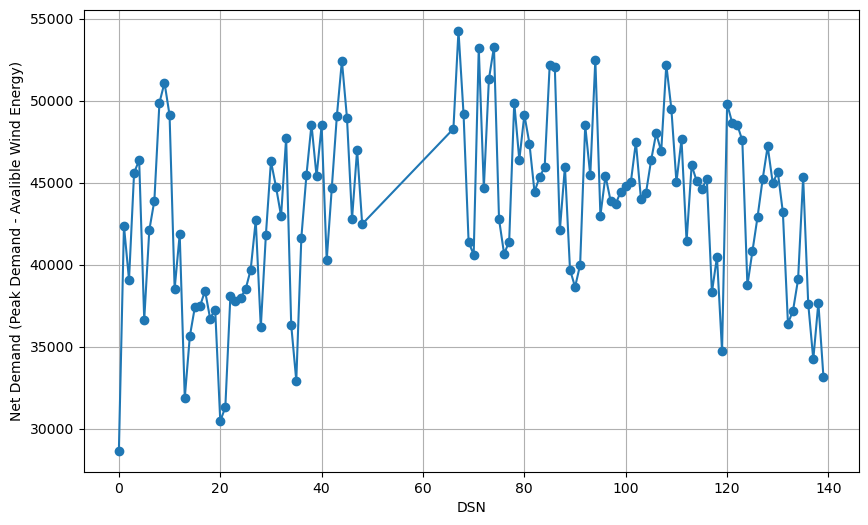

In [126]:
data_plot = merged_df[merged_df['start_year'] == 2009]
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'peak_demand' and 'offshore (current + future)' are columns in your DataFrame data_plot

# Assuming data_plot is your pandas DataFrame
data_plot['difference'] = data_plot['peak_demand'] - 15*1000*data_plot['offshore (current + future)']

# Plotting the difference
plt.figure(figsize=(10, 6))
plt.plot(data_plot['DSN'], data_plot['difference'], marker='o', linestyle='-')



plt.xlabel('DSN')
plt.ylabel('Net Demand (Peak Demand - Avalible Wind Energy)')
plt.grid(True)
plt.show()

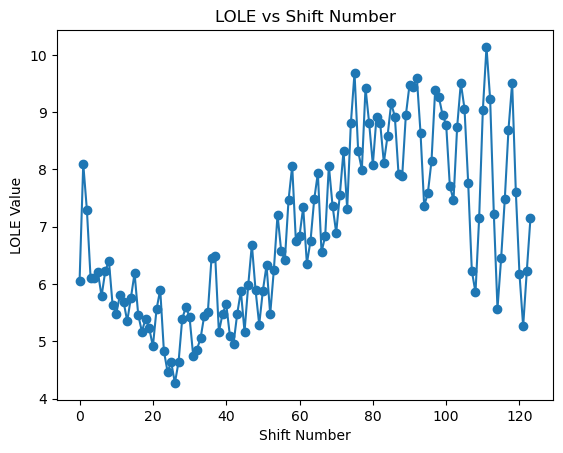

In [124]:
# 2009
import matplotlib.pyplot as plt
data_plot = merged_df[merged_df['start_year'] == 2009]

# Number of shifts you want to perform
num_shifts = len(data_plot)

# Lists to store results for plotting
shift_numbers = []
LOLE_values = []

# Initial LOLE calculation
# Initial LOLE calculation
current_LOLE = LOLE(1, data_plot['peak_demand'], 15*1000 * data_plot['offshore (current + future)'])
shift_numbers.append(0)
LOLE_values.append(current_LOLE)

# Perform shifts and calculate LOLE for each shift
for shift_number in range(1, num_shifts + 1):
    # Shift the data
    data_plot = Shift_GAM(data_plot)
    
    # Calculate LOLE for the shifted data
    current_LOLE = LOLE(1, data_plot['peak_demand'], 15*1000 * data_plot['offshore (current + future)'])
    
    # Append results to lists
    shift_numbers.append(shift_number)
    LOLE_values.append(current_LOLE)

more = pd.read_csv('urgent_2.csv')
# Plot the results
plt.plot(shift_numbers, LOLE_values, marker='o', label ='GAM')
plt.xlabel('Shift Number')
plt.ylabel('LOLE Value')
plt.title('LOLE vs Shift Number')
plt.show()





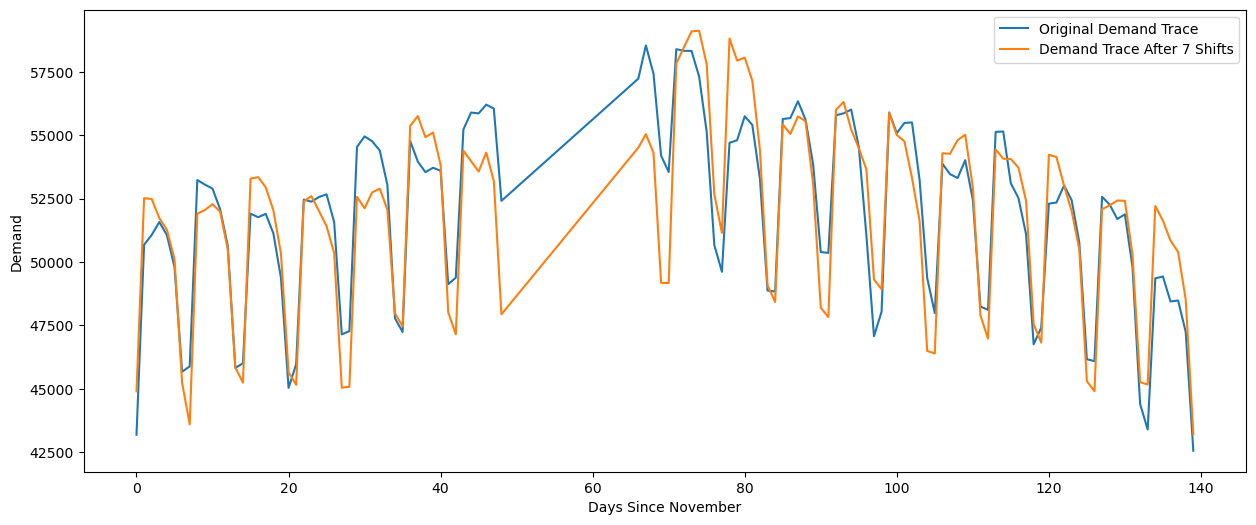

In [20]:
merged_df= merged_data 

# Sample data
import matplotlib.pyplot as plt
data_2004 = merged_df[merged_df['start_year'] == 2009].reset_index(drop=True)

data_2004.reset_index(drop=True, inplace=True)

data_2004_orig = data_2004.copy()

# Define the number of shifts
shifts_to_plot = [7]

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(data_2004_orig['DSN'],data_2004_orig['peak_demand'], label='Original Demand Trace')


j = 0
while j < shifts_to_plot[0]: 
    Shift_GAM(data_2004_orig)
    j = j +1 

data_2004_orig = data_2004_orig.sort_values(by='DSN')
    
plt.plot(data_2004_orig['DSN'], data_2004_orig['peak_demand'], label=f'Demand Trace After {shifts_to_plot[0]} Shifts')    
   
data_2004 = merged_df[merged_df['start_year'] == 2009].reset_index(drop=True)
data_2004.reset_index(drop=True, inplace=True)


plt.xlabel('Days Since November')
plt.ylabel('Demand')
plt.legend()
plt.show()

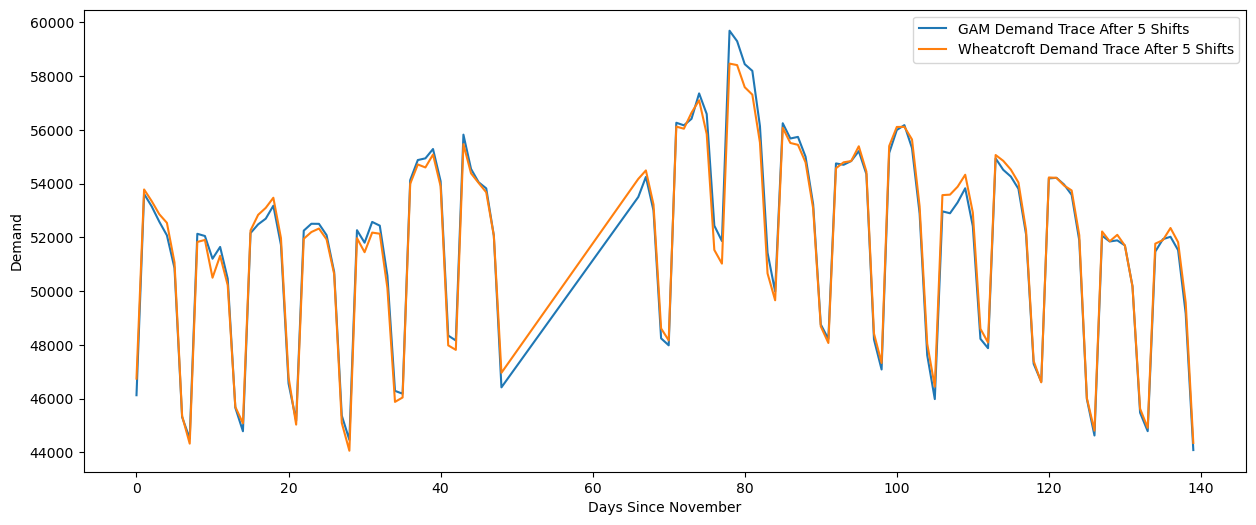

In [117]:
merged_df= merged_data 

# Sample data
import matplotlib.pyplot as plt
data_2004 = merged_df[merged_df['start_year'] == 2009].reset_index(drop=True)

data_2004.reset_index(drop=True, inplace=True)

data_2004_orig = data_2004.copy()

# Define the number of shifts
shifts_to_plot = [5,10]

# Plotting
plt.figure(figsize=(15, 6))

data_2004 = merged_df[merged_df['start_year'] == 2009].reset_index(drop=True)
data_2004.reset_index(drop=True, inplace=True)

data_2004_orig = data_2004.copy()

j = 0
while j < shifts_to_plot[1]: 
    Shift_GAM(data_2004_orig)
    j = j +1 
    
data_2004_orig = data_2004_orig.sort_values(by='DSN')
plt.plot(data_2004_orig['DSN'], data_2004_orig['peak_demand'], label=f'GAM Demand Trace After {shifts_to_plot[0]} Shifts')        
plt.plot(urgent['DSN'], urgent['peak_demand'], label=f'Wheatcroft Demand Trace After {shifts_to_plot[0]} Shifts')            
plt.xlabel('Days Since November')
plt.ylabel('Demand')
plt.legend()
plt.show()

In [115]:
urgent = pd.read_csv('wheatcroft_now.csv')


In [20]:
data_plot = merged_df[merged_df['start_year'] == 2005]
Shift_GAM(data_plot)

,DOW2,demand_date,peak_demand,TO,TE,Winter,start_year,Nov_date,DSN,DOW,...,offshore (current + future),onshore (current),onshore (current + future),DOW2_7,DOW2_1,DOW2_2,DOW2_3,DOW2_4,DOW2_5,DOW2_6
1883,4,2005-11-01,53188.833690,9.601715,11.538631,2005,2005,2005-11-01,1.0,Wednesday,...,0.601929,0.325757,0.327100,0,0,0,0,1,0,0
1884,5,2005-11-02,52400.449620,14.930636,13.234633,2005,2005,2005-11-01,2.0,Thursday,...,0.893772,0.393193,0.391018,0,0,0,0,0,1,0
1885,6,2005-11-03,50950.678578,12.909579,13.072106,2005,2005,2005-11-01,3.0,Friday,...,0.872100,0.383822,0.375892,0,0,0,0,0,0,1
1886,7,2005-11-04,46491.625606,8.680171,10.876139,2005,2005,2005-11-01,4.0,Saturday,...,0.843499,0.358337,0.355692,1,0,0,0,0,0,0
1887,1,2005-11-05,46089.801390,11.566497,11.221318,2005,2005,2005-11-01,5.0,Sunday,...,0.813587,0.366816,0.363412,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007,4,2006-03-21,53829.635587,3.118200,3.992563,2005,2005,2005-11-01,141.0,Wednesday,...,0.478102,0.118302,0.117144,0,0,0,0,1,0,0
2008,5,2006-03-22,53925.542499,3.588911,3.790737,2005,2005,2005-11-01,142.0,Thursday,...,0.140120,0.095604,0.095799,0,0,0,0,0,1,0
2009,6,2006-03-23,52016.366316,5.879438,4.835087,2005,2005,2005-11-01,143.0,Friday,...,0.764972,0.266364,0.263468,0,0,0,0,0,0,1
2010,7,2006-03-24,45208.136772,9.051418,6.943253,2005,2005,2005-11-01,144.0,Saturday,...,0.665288,0.612956,0.617696,1,0,0,0,0,0,0


In [62]:
data_plot

,DOW2,demand_date,peak_demand,TO,TE,Winter,start_year,Nov_date,DSN,DOW,...,offshore (current + future),onshore (current),onshore (current + future),DOW2_7,DOW2_1,DOW2_2,DOW2_3,DOW2_4,DOW2_5,DOW2_6
3027,5,2014-11-01,47177.845074,12.157464,13.310764,2014,2014,2014-11-01,19.0,Thursday,...,0.868047,0.734327,0.734372,0,0,0,0,0,1,0
3028,6,2014-11-02,47045.902833,10.627186,11.968975,2014,2014,2014-11-01,20.0,Friday,...,0.718113,0.359161,0.361433,0,0,0,0,0,0,1
3029,7,2014-11-03,42632.644423,7.446604,9.707790,2014,2014,2014-11-01,21.0,Saturday,...,0.232345,0.121084,0.119313,1,0,0,0,0,0,0
3030,1,2014-11-04,42968.702319,7.050916,8.379353,2014,2014,2014-11-01,22.0,Sunday,...,0.247146,0.240221,0.244694,0,1,0,0,0,0,0
3031,2,2014-11-05,51019.952949,6.031577,7.205465,2014,2014,2014-11-01,23.0,Monday,...,0.203680,0.056951,0.055206,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3149,1,2015-03-17,43618.013929,7.410259,6.606769,2014,2014,2014-11-01,14.0,Sunday,...,0.186139,0.023501,0.023289,0,1,0,0,0,0,0
3150,2,2015-03-18,50733.836981,7.355932,6.981351,2014,2014,2014-11-01,15.0,Monday,...,0.490646,0.051511,0.050205,0,0,1,0,0,0,0
3151,3,2015-03-19,50635.989907,7.562099,7.271725,2014,2014,2014-11-01,16.0,Tuesday,...,0.402345,0.084395,0.084430,0,0,0,1,0,0,0
3152,4,2015-03-20,50138.393086,8.936487,8.104106,2014,2014,2014-11-01,17.0,Wednesday,...,0.310310,0.306464,0.310283,0,0,0,0,1,0,0


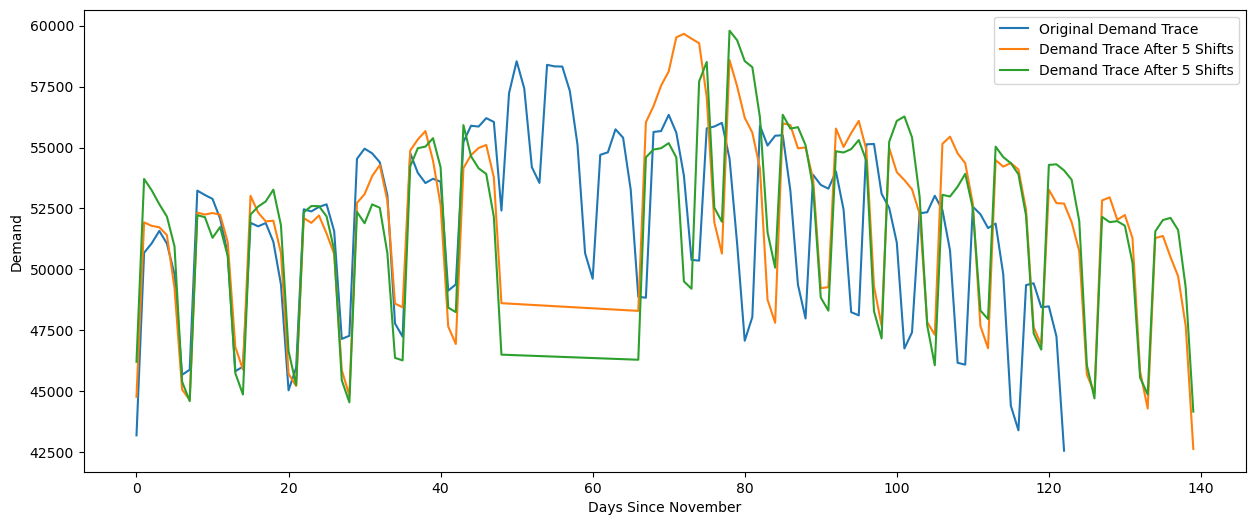

In [61]:
merged_df= merged_data 

# Sample data
import matplotlib.pyplot as plt
data_2004 = merged_df[merged_df['start_year'] == 2009].reset_index(drop=True)

data_2004.reset_index(drop=True, inplace=True)

data_2004_orig = data_2004.copy()

# Define the number of shifts
shifts_to_plot = [5,10]

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(data_2004_orig['peak_demand'], label='Original Demand Trace')


j = 0
while j < shifts_to_plot[0]: 
    Shift_GAM(data_2004_orig)
    j = j +1 

data_2004_orig = data_2004_orig.sort_values(by='DSN')
    
plt.plot(data_2004_orig['DSN'], data_2004_orig['peak_demand'], label=f'Demand Trace After {shifts_to_plot[0]} Shifts')    
   
data_2004 = merged_df[merged_df['start_year'] == 2009].reset_index(drop=True)
data_2004.reset_index(drop=True, inplace=True)

data_2004_orig = data_2004.copy()

j = 0
while j < shifts_to_plot[1]: 
    Shift_GAM(data_2004_orig)
    j = j +1 
    
data_2004_orig = data_2004_orig.sort_values(by='DSN')
plt.plot(data_2004_orig['DSN'], data_2004_orig['peak_demand'], label=f'Demand Trace After {shifts_to_plot[0]} Shifts')        
    
plt.xlabel('Days Since November')
plt.ylabel('Demand')
plt.legend()

NameError: name 'wheatcroft_10' is not defined

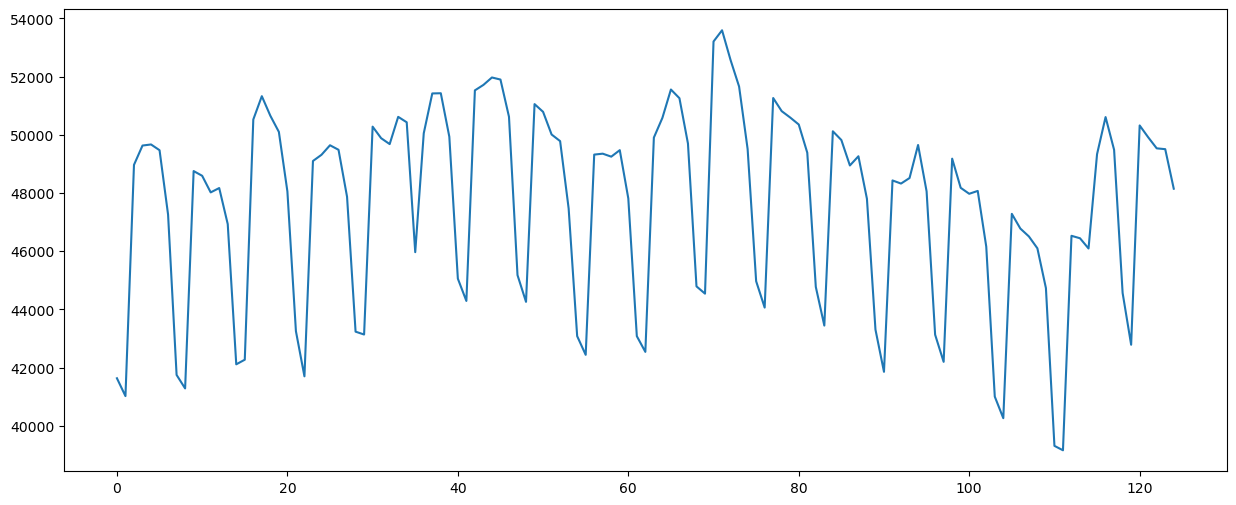

In [98]:
merged_df= merged_data 

# Sample data
import matplotlib.pyplot as plt
data_2004 = merged_df[merged_df['start_year'] == 1995].reset_index(drop=True)

data_2004.reset_index(drop=True, inplace=True)

data_2004_orig = data_2004.copy()

# Define the number of shifts
shifts_to_plot = [5,10]

# Plotting
plt.figure(figsize=(15, 6))
#plt.plot(data_2004_orig['peak_demand'], label='Original Demand Trace')


j = 0
while j < 10: 
    Shift_GAM(data_2004_orig)
    j = j +1 

plt.plot(data_2004_orig['peak_demand'], label=f'Demand Trace After {shifts_to_plot[1]} Shifts GAM')    
   

    
    
plt.plot(wheatcroft_10['peak_demand'], label=f'Demand Trace After {shifts_to_plot[1]} Shifts Wheatcroft')    
    
plt.xlabel('Days Since November')
plt.ylabel('Demand')
plt.legend()
plt.show()

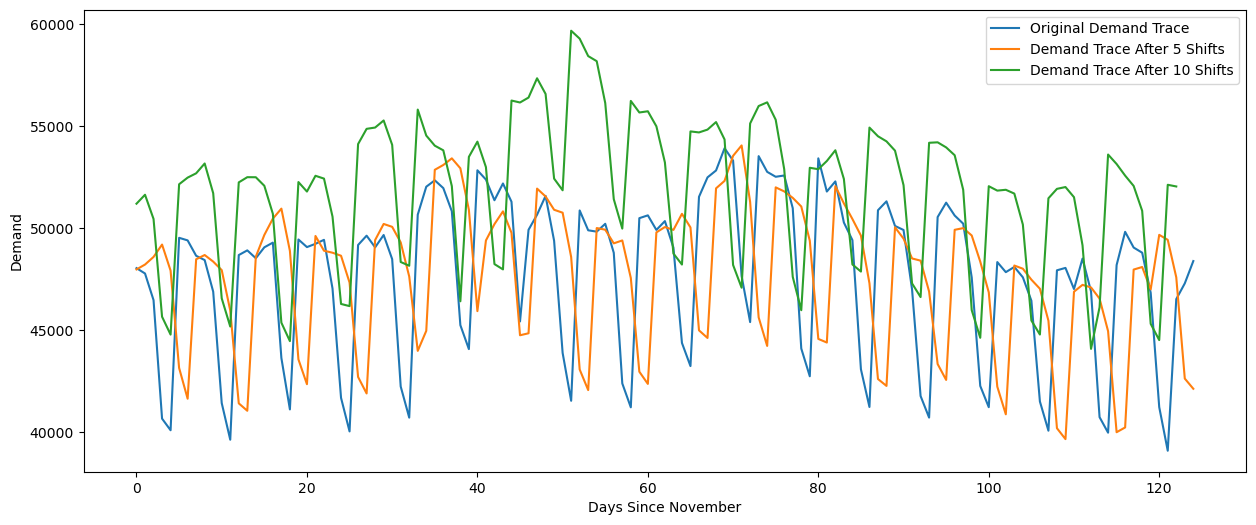

In [106]:
# Sample data
import matplotlib.pyplot as plt
data_2004 = merged_df[merged_df['start_year'] == 1995].reset_index(drop=True)
data_2004.reset_index(drop=True, inplace=True)
data_2004_orig = data_2004.copy()

# Define the number of shifts
shifts_to_plot = [5, 10]

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(data_2004_orig['peak_demand'], label='Original Demand Trace')


j = 0
while j < shifts_to_plot[0]:
    Shift_GAM(data_2004_orig)
    j += 1
plt.plot(data_2004_orig['peak_demand'], label=f'Demand Trace After {shifts_to_plot[0]} Shifts')

data_2004 = merged_df[merged_df['start_year'] == 2009].reset_index(drop=True)
data_2004.reset_index(drop=True, inplace=True)
data_2004_orig = data_2004.copy()

j = 0
while j < shifts_to_plot[1]:
    Shift_GAM(data_2004_orig)
    j += 1
plt.plot(data_2004_orig['peak_demand'], label=f'Demand Trace After {shifts_to_plot[1]} Shifts')

plt.xlabel('Days Since November')
plt.ylabel('Demand')
plt.legend()
plt.show()


In [ ]:
wheatcroft_10 = pd.read_csv('demand_data_10 Shifts.csv')

In [ ]:
data_plot

In [ ]:
from matplotlib import pyplot as plt 
import numpy as np 
from matplotlib.animation import FuncAnimation  
   
# initializing a figure in  
# which the graph will be plotted 
fig = plt.figure()  
   
# marking the x-axis and y-axis 
axis = plt.axes(xlim =(0, 100),  
                ylim =(40000, 60000))  
  
# initializing a line variable 
line, = axis.plot([], [], lw = 3)  
   
# data which the line will  
# contain (x, y) 
def init():  
    line.set_data([], []) 
    return line, 
   
def animate(i):
    
    data_plot = merged_df[merged_df['start_year'] == 2009]
    j = 0
    while j < i:
        Shift_GAM(data_plot)
       
    
    x = data_plot['DSN']
    y = data_plot['peak_demand']
   
    line.set_data(x, y) 
      
    return line, 
   
anim = FuncAnimation(fig, animate, init_func = init, 
                     frames = 100, interval = 1, blit = True) 
  
   
anim.save('continuousSineWave.gif',  
          writer = 'ffmpeg', fps = 30) 

In [ ]:
def animate(i):
    data_plot = merged_df[merged_df['start_year'] == 2009]
    
    # Shift the data i times
    for _ in range(i):
        Shift_GAM(data_plot)
    
    x = data_plot['DSN']
    y = data_plot['peak_demand']
   
    line.set_data(x, y) 
      
    return line, 

In [ ]:
from matplotlib import pyplot as plt 
import numpy as np 
from matplotlib.animation import FuncAnimation  
   
# initializing a figure in  
# which the graph will be plotted 
fig = plt.figure()  
   
# marking the x-axis and y-axis 
axis = plt.axes(xlim =(0, 123),  
                ylim =(40000, 60000))  
  
# initializing a line variable 
line, = axis.plot([], [], lw = 3)  
   
# data which the line will  
# contain (x, y) 
def init():  
    line.set_data([], []) 
    return line, 
   
def animate(i):
    data_plot = merged_df[merged_df['start_year'] == 2009]
    
    # Shift the data i times
    for _ in range(i):
        Shift_GAM(data_plot)
    
    x = np.arange(len(data_plot))
    y = data_plot['peak_demand']
   
    line.set_data(x, y) 
      
    return line, 
   
anim = FuncAnimation(fig, animate, init_func = init, 
                     frames = 100, interval = 1, blit = True) 
  
   
anim.save('continuousSineWave.gif',  
          writer = 'ffmpeg', fps = 10) 

In [ ]:
len(data_plot)

MovieWriter ffmpeg unavailable; using Pillow instead.


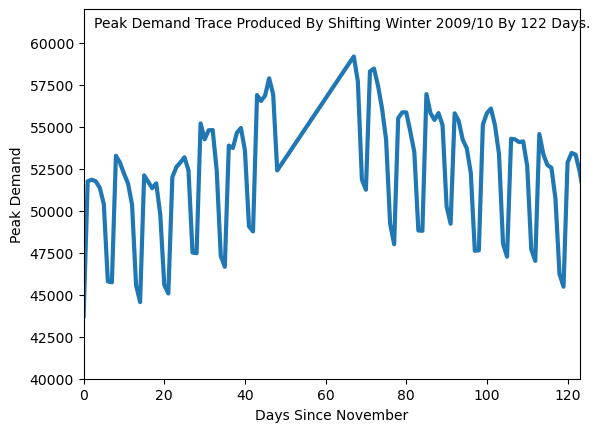

In [103]:
from matplotlib import pyplot as plt 
import numpy as np 
from matplotlib.animation import FuncAnimation  

# initializing a figure in  
# which the graph will be plotted 
fig = plt.figure()  

# marking the x-axis and y-axis 
axis = plt.axes(xlim =(0, 123),  
                ylim =(40000, 62000))  

# initializing a line variable 
line, = axis.plot([], [], lw = 3)  

# initializing text for caption
text = axis.text(0.02, 0.95, '', transform=axis.transAxes)

# Set axis labels
plt.xlabel('Days Since November')
plt.ylabel('Peak Demand')

# data which the line will  
# contain (x, y) 
def init():  
    line.set_data([], []) 
    text.set_text('')
    return line, text

def animate(i):
    data_plot = merged_df[merged_df['start_year'] == 2009]
    
    # Shift the data i times
    for _ in range(i):
        Shift_GAM(data_plot)
    
    
    data_plot = data_plot.sort_values(by='DSN')
    x = data_plot['DSN']
    y = data_plot['peak_demand']
   
    line.set_data(x, y)
    text.set_text(f'Peak Demand Trace Produced By Shifting Winter 2009/10 By {i} Days.')
      
    return line, text

anim = FuncAnimation(fig, animate, init_func=init, 
                     frames=123, interval=1, blit=True) 

anim.save('GAM.gif', writer='ffmpeg', fps=10)
